# A Bayesian Neural Net Demo for Turing

## Get started

Let's start by loading packages. 

`Turing` is our PPL framework and other pacakges are for plotting purpose.

In [2]:
using Turing
using Reactive, Interact, Gadfly
include(Pkg.dir("Turing")*"/notebooks/data/bayesNN-helper.jl");

## The Model

The Neural Network defined in this demo is shwon in the figure below.

<img src="fig/bnn.png">

## Training Data

Next, let's generate some training data and make a plotting.

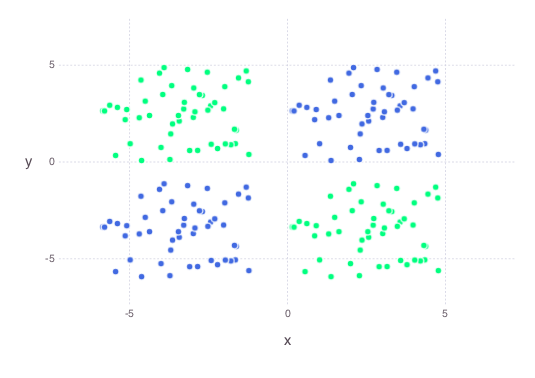

In [3]:
# Generating 200 training data
N = 200
M = round(Int64, N / 4)
x1s = rand(M) * 5
x2s = rand(M) * 5
xt1s = Array([[x1s[i]; x2s[i]] for i = 1:M])
append!(xt1s, Array([[x1s[i] - 6; x2s[i] - 6] for i = 1:M]))
xt0s = Array([[x1s[i]; x2s[i] - 6] for i = 1:M])
append!(xt0s, Array([[x1s[i] - 6; x2s[i]] for i = 1:M]))

xs = [xt1s; xt0s];
ts = [ones(M); ones(M); zeros(M); zeros(M)];

# Plot data points
d1_layer = layer(x=map(e -> e[1], xt1s), y=map(e -> e[2], xt1s), Geom.point, Theme(default_color=colorant"royalblue"))
d2_layer = layer(x=map(e -> e[1], xt0s), y=map(e -> e[2], xt0s), Geom.point, Theme(default_color=colorant"springgreen"))

plot(d1_layer, d2_layer, Coord.Cartesian(xmin=-7, xmax=7, ymin=-7, ymax=7))

## Model in Turing

The neural network is defined in Turing as below.

In [4]:
# Define the model
alpha = 0.16            # regularizatin term
var = sqrt(1.0 / alpha) # variance of the Gaussian prior
@model bnn begin
  @assume w11 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume w12 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume w13 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume w14 ~ MvNormal([0; 0], [var 0; 0 var])
  @assume b1 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])

  @assume w21 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])
  @assume w22 ~ MvNormal([0 ;0; 0; 0], [var 0 0 0; 0 var 0 0; 0 0 var 0; 0 0 0 var])
  @assume b2 ~ MvNormal([0 ;0], [var 0; 0 var])

  @assume wo ~ MvNormal([0; 0], [var 0; 0 var])
  @assume bo ~ Normal(0, var)

  for i = rand(1:N, 25)
    y = nn(xs[i], b1, w11, w12, w13, w14, b2, w21, w22, bo, wo)
    @observe ts[i] ~ Bernoulli(y)
  end
  @predict b1 w11 w12 w13 w14 b2 w21 w22 bo wo
end

bnn (generic function with 1 method)

## Training

Let's call `sample()` to train the model.

Note this model has 25 dimensions and would take ~25s to get 1000 samples.

In [5]:
@time chain = sample(bnn, HMC(1000, 0.1, 5));

[HMC]: Finshed with accept rate = 0.401 (re-runs for 0 times)
 36.805221 seconds (104.77 M allocations: 6.350 GB, 4.12% gc time)


## Prediction

The Bayesian prediciton result is then shown below.

This is an interactive plot, in which you can change the ratio of samples in the chain to see the evoluation of training.

Interact.Slider{Float64}(Signal{Float64}(0.46, nactions=0),"ratio",0.46,0.01:0.05:0.9600000000000001,true)

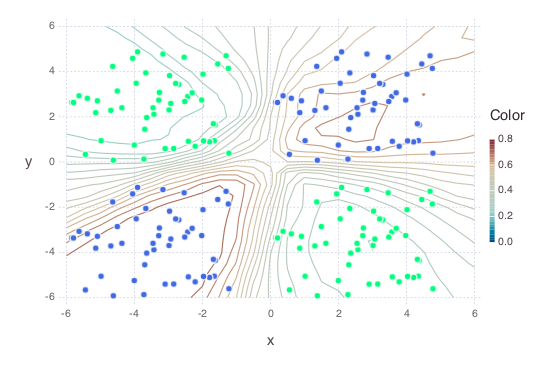

In [6]:
@manipulate for
    ratio = 0.01:0.05:1
    p_layer = layer(z=(x,y) -> predict([x, y], chain, ratio), x=linspace(-6,6,25), y=linspace(-6,6,25), Geom.contour)
    plot(d1_layer, d2_layer, p_layer, Coord.cartesian(xmin=-6, xmax=6, ymin=-6, ymax=6))
end